In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from copy import deepcopy
import os
import os.path as op
import sys
from matplotlib import pyplot as plt
%matplotlib

loc = 'workstation'
if loc == 'laptop':
    #eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/student_projects/EffortDifficulty/analysis/tools'
    eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/tools'
    wd         = '/Users/sammichekroud/Desktop/postdoc/wmconfidence' #working on confidence data, but in postdoc dir
elif loc == 'workstation':
    eyefuncdir = 'C:/Users/sammirc/Desktop/postdoc/tools/'
    wd         =  'C:/Users/sammirc/Desktop/postdoc/tuningcurves'
os.chdir(wd)
sys.path.insert(0, eyefuncdir)

bdir   = op.join(wd, 'data', 'datafiles')

subs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,     11, 12, 13, 14, 15, 16, 17, 18,     20, 21, 22,     24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,             13, 14, 15,     17,         20, 21, 22,     24, 25, 26])
nsubs = subs.size

#set some params here
modeltimes = np.round(np.load(op.join(wd, 'data', 'tuningcurves', 'times.npy')), 2)
eegtimes   = np.round(np.load(op.join(wd, 'data', 'glms', 'eeg', 'glm1', 'eeg_times.npy')), 2)
regnames   = np.load(op.join(wd, 'data', 'glms', 'eeg', 'glm1', 'regressor_names.npy'))

nparams = regnames.size
#ppts x tuning curve timepoints x regressors x1
b = np.zeros(shape = [nsubs, nparams, modeltimes.size, eegtimes.size]) * np.nan
t = np.zeros(shape = [nsubs, nparams, modeltimes.size, eegtimes.size]) * np.nan

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
use_b = True
if use_b:
    paramind = 0
    addtext = 'modelAmplitudeBeta'
elif not use_b:
    paramind = 1
    addtext = 'modelAmplitudeTvalue'
fittype = 'glm'
if fittype == 'opt':
    fittext = 'b1optfit'
elif fittype == 'glm':
    fittext = 'b1glmfit'

#use a model that predicts log-transformed power (10*log10) so looking at decibels
logdata = True
if logdata:
    logtxt = '_logpower'
else:
    logtxt = ''

# use the output froma  model that uses lightly smoothed amplitude estimates across time? reduces some noise at single trial level
smoothamp = True
if smoothamp:
    #smoothed amplitude estimate lightly over time   
    amptxt = '_smoothamp'
elif not smoothamp:
    amptxt = ''

subcount = -1
for sub in subs:
    subcount += 1
    ib = np.load(op.join(wd, 'data', 'glms', 'eeg', 'glm1', f'wmc_s{sub:02d}_glm1{logtxt}_betas_{fittext}_{addtext}{amptxt}.npy')) #has shape: tuning curve time x regressors x eyetracker time
    it = np.load(op.join(wd, 'data', 'glms', 'eeg', 'glm1', f'wmc_s{sub:02d}_glm1{logtxt}_tvalues_{fittext}_{addtext}{amptxt}.npy'))
    b[subcount] = ib.copy()
    t[subcount] = it.copy()
bm = np.nanmean(b, axis=0) #average across participants
tm = np.nanmean(t, axis=0)

<font color='red'>

For the regression that is fit at each time point, we are using lightly smoothed values of tuning curve precision (3sd gaussian blur) and amplitude (2sd blur) in the timepoint-wise regression. This smooths out some of the single-trial noise. We are also looking at log-transformed (10 * log10) power, making this decibels when looking at alpha power.

first, we want to look at beta weights across time. We're looking at how variability in alpha power at each time point is associated with variability in the estimated tuning curve parameters, also across time.

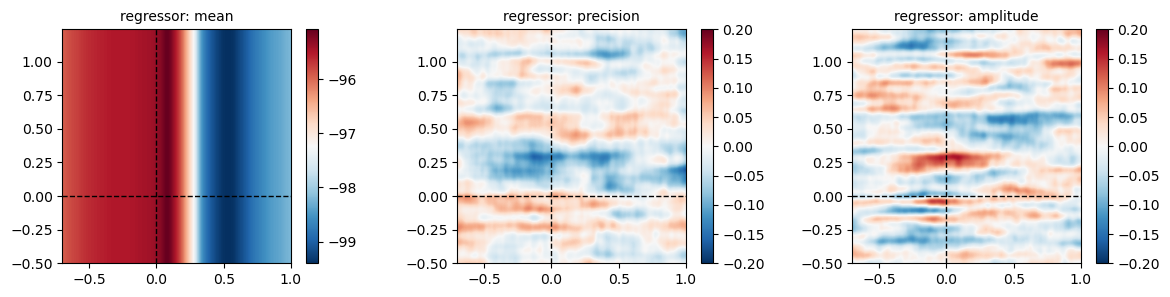

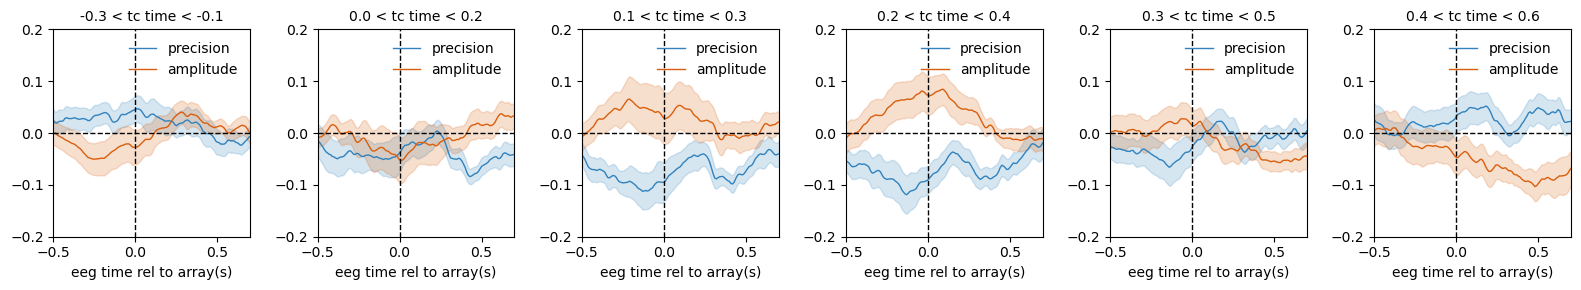

In [3]:
check_b = True
if check_b:
    dat = bm.copy()
    d = b.copy()
else:
    dat = tm.copy()
    d = t.copy()
fig = plt.figure(figsize = [12, 3])
for iparam in range(nparams):
    if iparam == 0:
        if check_b:
            vmin, vmax = None, None
        else:
            vmin, vmax = None, None
    else:
        if check_b:
            vmin, vmax = -3e-11, 3e-11 #for non log transformed power
            vmin, vmax = -0.2, 0.2 # for log transformed power
        else:
            vmin, vmax = -1, 1 #for non log-transformed power
            vmin, vmax = -1.5, 1.5 #for log transformed power
    ax = fig.add_subplot(1, 3, iparam+1)
    plot = ax.imshow(dat[iparam].squeeze(), aspect= 'equal', interpolation='gaussian', cmap='RdBu_r', origin = 'lower',
                     vmin = vmin, vmax = vmax, 
                     extent = [eegtimes.min(), eegtimes.max(), modeltimes.min(), modeltimes.max()])
    ax.set_title(f'regressor: {regnames[iparam]}', fontsize = 10)
    ax.axvline(0, ls = 'dashed', color = 'k', lw = 1)
    ax.axhline(0, ls = 'dashed', color = 'k', lw = 1)
    fig.colorbar(plot)
fig.tight_layout()

mstarts = [-0.3, 0.0, 0.1, 0.2, 0.3, 0.4]
mends   = [-0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e']
fig = plt.figure(figsize = [16, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    # print(iplot, istart, iend)
    ax = fig.add_subplot(1, nplots, iplot+1)
    tinds = np.logical_and(modeltimes >= istart, modeltimes <= iend)
    plotd = d[:, :, tinds].mean(axis=2) #average across the timewindow
    plotm = plotd.mean(axis=0) #average across participants
    plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

    #loop over regressors
    for ireg in range(2):
        ax.plot(eegtimes, plotm[ireg+1], label = regnames[ireg+1], lw = 1, c = cols[ireg])
        ax.fill_between(eegtimes,
                        np.add(plotm[ireg+1], plotsem[ireg+1]),
                        np.subtract(plotm[ireg+1], plotsem[ireg+1]),
                        edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart} < tc time < {iend}', fontsize = 10)
    
    if check_b:
        ax.set_ylim([-4e-11, 4e-11]) #for non log transformed power
        ax.set_ylim([-0.2, 0.2]) #for log transformed power
    elif not check_b:
        ax.set_ylim([-1, 1])
    ax.set_xlim([-0.5, 0.7])
    ax.set_xlabel('eeg time rel to array(s)', fontsize = 10)
    ax.legend(loc = 'upper right', frameon=False)
fig.tight_layout()

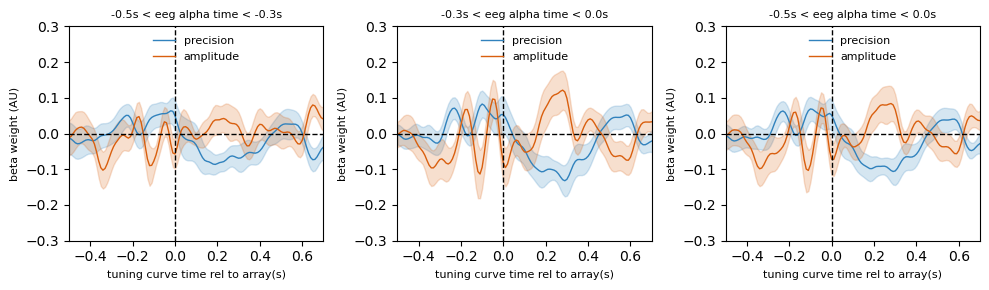

In [4]:
if check_b:
    dat = bm.copy()
    d = b.copy()
else:
    dat = tm.copy()
    d = t.copy()

mstarts = [-0.5, -0.3, -0.5]
mends   = [-0.3,  0.0,  0.0]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e']
labs = ['precision', 'amplitude']
fig = plt.figure(figsize = [10, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    ax = fig.add_subplot(1, nplots, iplot+1)
    # print(iplot, istart, iend)
    tinds = np.logical_and(eegtimes >= istart, eegtimes <= iend)
    for ireg in range(2):
        plotd = d[:,:,:,tinds].mean(-1)
        plotd = plotd[:,ireg+1] #take just the relevant parameter
        plotm = plotd.mean(axis=0) #average across participants
        plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')
    
        ax.plot(modeltimes, plotm, label = labs[ireg], lw = 1, c = cols[ireg])
        ax.fill_between(modeltimes,
                        np.add(plotm, plotsem),
                        np.subtract(plotm, plotsem),
                        edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart}s < eeg alpha time < {iend}s', fontsize = 8)
    if check_b:
        ax.set_ylim([-4e-11, 4e-11]) #for non log transformed power
        ax.set_ylim([-0.3, 0.3]) #for log transformed power
    elif not check_b:
        ax.set_ylim([-1.2, 1.2])
    ax.set_xlim([-0.5, 0.7])
    ax.set_xlabel('tuning curve time rel to array(s)', fontsize = 8)
    ax.set_ylabel('beta weight (AU)', fontsize = 8)
    ax.legend(loc = 'upper center', frameon=False, fontsize=8)
fig.tight_layout()

<font color='blue'>

next, we can run the exact same pipeline but instead of looking at output beta weights across participants, we look at output t-values for each time point. This weights the estimate by the variability in the estimate, and is possibly more sensitive to effects vs noise.

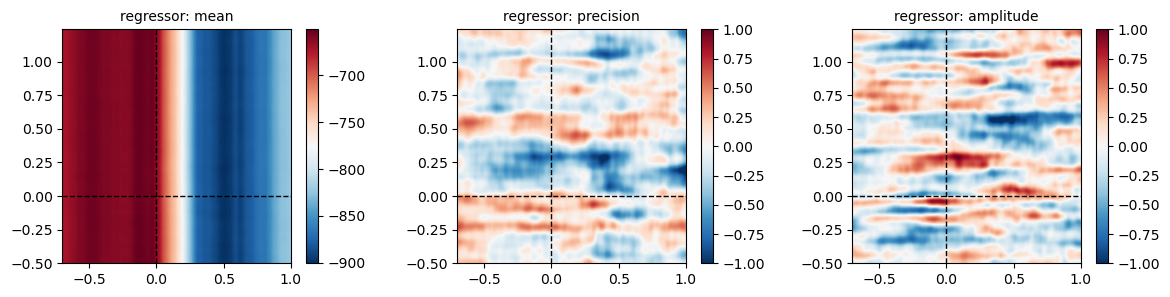

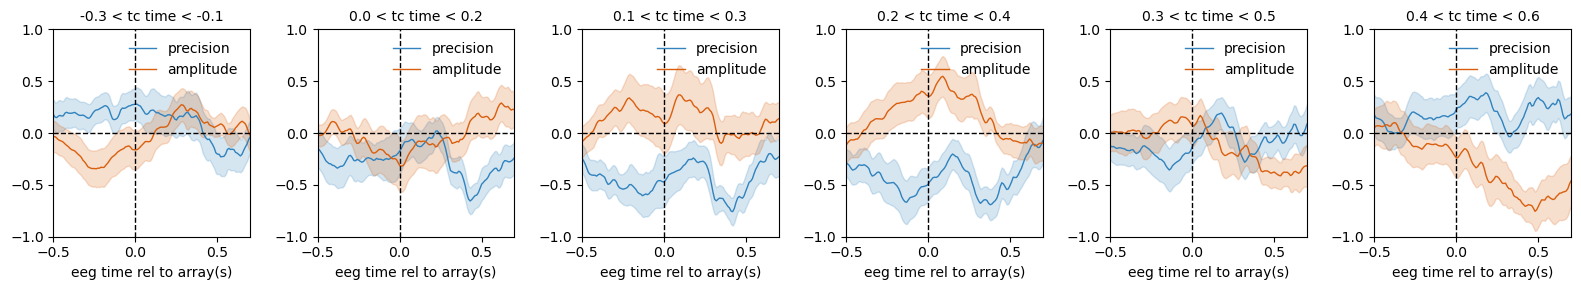

In [7]:
check_b = False
if check_b:
    dat = bm.copy()
    d = b.copy()
else:
    dat = tm.copy()
    d = t.copy()
fig = plt.figure(figsize = [12, 3])
for iparam in range(nparams):
    if iparam == 0:
        if check_b:
            vmin, vmax = None, None
        else:
            vmin, vmax = None, None
    else:
        if check_b:
            vmin, vmax = -3e-11, 3e-11 #for non log transformed power
            vmin, vmax = -0.2, 0.2 # for log transformed power
        else:
            vmin, vmax = -1, 1 #for non log-transformed power
            vmin, vmax = -1, 1#for log transformed power
    ax = fig.add_subplot(1, 3, iparam+1)
    plot = ax.imshow(dat[iparam].squeeze(), aspect= 'equal', interpolation='gaussian', cmap='RdBu_r', origin = 'lower',
                     vmin = vmin, vmax = vmax, 
                     extent = [eegtimes.min(), eegtimes.max(), modeltimes.min(), modeltimes.max()])
    ax.set_title(f'regressor: {regnames[iparam]}', fontsize = 10)
    ax.axvline(0, ls = 'dashed', color = 'k', lw = 1)
    ax.axhline(0, ls = 'dashed', color = 'k', lw = 1)
    fig.colorbar(plot)
fig.tight_layout()

mstarts = [-0.3, 0.0, 0.1, 0.2, 0.3, 0.4]
mends   = [-0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e']
fig = plt.figure(figsize = [16, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    # print(iplot, istart, iend)
    ax = fig.add_subplot(1, nplots, iplot+1)
    tinds = np.logical_and(modeltimes >= istart, modeltimes <= iend)
    plotd = d[:, :, tinds].mean(axis=2) #average across the timewindow
    plotm = plotd.mean(axis=0) #average across participants
    plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

    #loop over regressors
    for ireg in range(2):
        ax.plot(eegtimes, plotm[ireg+1], label = regnames[ireg+1], lw = 1, c = cols[ireg])
        ax.fill_between(eegtimes,
                        np.add(plotm[ireg+1], plotsem[ireg+1]),
                        np.subtract(plotm[ireg+1], plotsem[ireg+1]),
                        edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart} < tc time < {iend}', fontsize = 10)
    
    if check_b:
        ax.set_ylim([-4e-11, 4e-11]) #for non log transformed power
        ax.set_ylim([-0.2, 0.2]) #for log transformed power
    elif not check_b:
        ax.set_ylim([-1, 1])
    ax.set_xlim([-0.5, 0.7])
    ax.set_xlabel('eeg time rel to array(s)', fontsize = 10)
    ax.legend(loc = 'upper right', frameon=False)
fig.tight_layout()

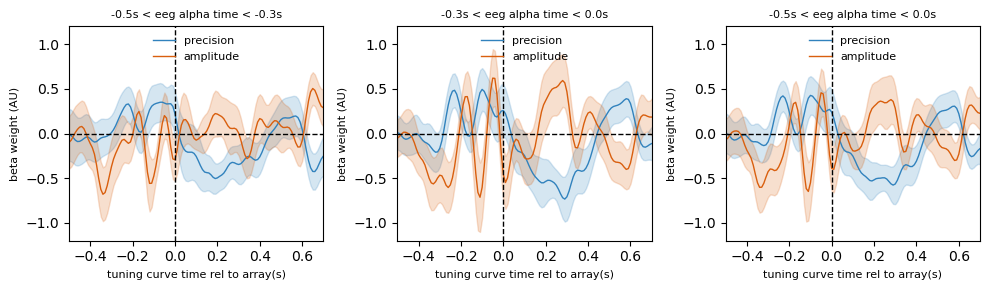

In [8]:
if check_b:
    dat = bm.copy()
    d = b.copy()
else:
    dat = tm.copy()
    d = t.copy()

mstarts = [-0.5, -0.3, -0.5]
mends   = [-0.3,  0.0,  0.0]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e']
labs = ['precision', 'amplitude']
fig = plt.figure(figsize = [10, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    ax = fig.add_subplot(1, nplots, iplot+1)
    # print(iplot, istart, iend)
    tinds = np.logical_and(eegtimes >= istart, eegtimes <= iend)
    for ireg in range(2):
        plotd = d[:,:,:,tinds].mean(-1)
        plotd = plotd[:,ireg+1] #take just the relevant parameter
        plotm = plotd.mean(axis=0) #average across participants
        plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')
    
        ax.plot(modeltimes, plotm, label = labs[ireg], lw = 1, c = cols[ireg])
        ax.fill_between(modeltimes,
                        np.add(plotm, plotsem),
                        np.subtract(plotm, plotsem),
                        edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart}s < eeg alpha time < {iend}s', fontsize = 8)
    if check_b:
        ax.set_ylim([-4e-11, 4e-11]) #for non log transformed power
        ax.set_ylim([-0.3, 0.3]) #for log transformed power
    elif not check_b:
        ax.set_ylim([-1.2, 1.2])
    ax.set_xlim([-0.5, 0.7])
    ax.set_xlabel('tuning curve time rel to array(s)', fontsize = 8)
    ax.set_ylabel('beta weight (AU)', fontsize = 8)
    ax.legend(loc = 'upper center', frameon=False, fontsize=8)
fig.tight_layout()